# 중고자동차 가격 예측
---

## 데이터 소개
    - kaggle에서 제공하는 Used Car Dataset
    - 스크래핑으로 수집된 데이터
    
    - vehicles.csv
    id : 중고차 거래의 아이디
    url : 중고차 거래 페이지
    region : 해당 거래의 관리 지점
    region_url : 거래 관리 지점의 홈페이지
    price : 기입된 자동차의 거래가
    year : 중고차의 생산연도
    manufacturer : 자동차를 생산한 회사
    model : 자동차 모델명
    condition : 자동차의 상태
    cylinders : 자동차의 기통 수
    fuel : 자동차의 연료 타입
    odometer : 자동차의 운행 마일 수
    title_status : 자동차의 타이틀 상태 (소유주 등록 상태)
    transmission : 자동차의 트랜스미션 종류
    vin : 자동차의 식별 번호 (vehicle identification number)
    drive : 자동차의 구동 타입
    size : 자동차 크기
    type : 자동차의 일반 타입 (세단, ...)
    paint_color : 자동차 색상
    image_url : 자동차 이미지
    description : 세부 설명
    county : 실수로 생성된 미사용 컬럼
    state : 거래가 업로드된 미 주
    lat : 거래가 업로드된 곳의 위도
    long : 거래가 업로드된 곳의 경도
 
    
- 데이터 출처: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

## 데이터 스크래핑

- 일반적으로 웹에서 스크랩을 한다고 할 경우 html내에서 데이터의 형식을 예측해서, 해당 형식의 데이터를 가져오도록 지정 (by selenium)<br><br>
- 다만 이 경우 해당 페이지의 위치가 리뉴얼 되거나 하는 등의 변동이 있을때 위에 말한 '예측' 대로 데이터가 수집되지 않을 가능성이 높다.<br><br>
- 즉, 이상치(outlier) 데이터가 다량 발생할 가능성이 많다.<br>
    - 빈 데이터를 스크랩한 경우<br>
    - 형식이 틀린 경우 <br>
        - 문자열 : 앞뒤에 공백, html태그 포함하여 스크랩, 인코딩에 의해 깨진 문자<br>
        - 숫자 : 최대값 & 최소값으로 잘못 기입 되는 경우, 숫자 대신 문자열로 스크랩된 경우<br>

## 데이터셋 불러오기

In [81]:
# 기초 전처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

# 기본 캔버스 사이즈 적용
plt.rcParams['figure.figsize'] = (12, 9)

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

In [82]:
df = pd.read_csv('vehicles.csv')

## EDA 및 데이터 기초 통계 분석

In [83]:
# 전체 데이터 탐색
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.00,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.00,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.59,-85.48,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.00,hyundai,sonata,excellent,4 cylinders,gas,93600.00,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.55,-85.47,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.00,bmw,x3 3.0i,good,6 cylinders,gas,87046.00,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.62,-85.46,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.00,chevrolet,c-10,good,4 cylinders,gas,190000.00,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.86,-85.22,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.00,ford,f350 lariat,excellent,8 cylinders,diesel,116000.00,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.55,-85.47,2020-12-01T12:53:56-0600


In [84]:
print(df['year'].unique())
max(df['year'].unique())

[2010. 2014. 2006. 1974. 2005. 2016. 2012. 2017. 2019. 2013. 2003.   nan
 1996. 2020. 2018. 2009. 2015. 1986. 2004. 2011. 2007. 2008. 1990. 1999.
 1961. 1997. 2000. 1976. 1992. 1968. 2002. 1979. 1991. 1956. 2001. 1998.
 1988. 1993. 1955. 1971. 1978. 1957. 1964. 1994. 1966. 1982. 1962. 1941.
 1930. 1995. 1946. 1981. 1967. 1963. 1950. 1937. 1954. 1969. 1911. 1973.
 1983. 1989. 1984. 1929. 1972. 1987. 1977. 1965. 1985. 1936. 1953. 1980.
 1912. 1926. 1940. 2021. 1970. 1975. 1960. 1924. 1931. 1951. 1928. 1948.
 1949. 1934. 1952. 1919. 1947. 1933. 1939. 1958. 1959. 1938. 1932. 1923.
 1935. 1927. 1945. 1900. 1922. 1942. 1925. 1913. 1918. 1920. 1914. 1915.
 1943. 1910. 1921.]


2021.0

In [85]:
df[['year','price']].corr()

,year,price
year,1.00,-0.00
price,-0.00,1.00


In [86]:
df['condition'].unique()

array(['good', 'excellent', nan, 'like new', 'fair', 'salvage', 'new'],
      dtype=object)

In [87]:
df['cylinders'].unique()

array(['8 cylinders', '4 cylinders', '6 cylinders', nan, '10 cylinders',
       'other', '5 cylinders', '3 cylinders', '12 cylinders'],
      dtype=object)

In [88]:
df['fuel'].unique()

array(['gas', 'diesel', 'other', 'hybrid', nan, 'electric'], dtype=object)

In [89]:
df['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [90]:
df['type'].unique()

array(['other', 'sedan', 'SUV', 'pickup', 'coupe', 'van', nan, 'truck',
       'mini-van', 'wagon', 'convertible', 'hatchback', 'bus', 'offroad'],
      dtype=object)

- Unnamed:0 (df의 index #), id 컬럼은 분석에 불필요한 컬럼이므로 drop 필요
- year(중고차 생산연도) : 가장 최신이 2021이므로 단순하게 회귀를 돌리면 2021에 가까울 수록 가격이 높게 예측될 수 있다.
    - 추가로 전체 데이터 중 시작연도가 불분명하기 때문에 그대로 사용하기 어려움
    - 해당 데이터를 사용하기 위해서는 전처리를 통해 조정 해줄 필요가 있음
- manufacturer : 생산사 데이터
    - 해당 데이터 기준으로 종류별, 생산년도별 등 기준에 따른 가격을 통해 브랜드 선호도 등을 파악할 수 있을 듯
    - 즉, 가격 결정에 중요한 요인이 될 수 있는 변수로 예상 됨
- odometer : 몇몇 데이터는 정수로 떨어지는것에 비해 디테일한 값도 있다.
    - 정확하지 않게 대략적으로 기입된 데이터들이 있을 수 있음.
    - 해당 데이터의 처리법을 고민 해볼 필요 있음
    - binning을 통해 구간으로 나눠 categorical로 나누는 것도 방법일듯.(시각화 하여 확인 필요)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [92]:
df.isna().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url           28
description         70
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

- 약 45만개 데이터
- 중요하리라 예상한 manufacturer이 누락치가 18000여개
    - 45만개 대비로 보면 큰 수치는 아니지만, 중요 변수로 예상되기 때문에 필요시 drop할 필요 있어 보임.
- condition : 45만개중 약 20만개로 상당히 큰 비중의 누락치 
    - 중요하지 않다면 condition자체를 drop하면 되지만, 상식적으로 생각해도 꽤 유의미한 데이터 일 것으로 예상
    - 다른 컬럼을 기반으로 참조해서 전처리를 통해 채워넣어야 할 필요성이 있어 보임
- cylinders 도 condition과 마찬가지
- paintcolor의 경우 도 꽤 중요할 것으로 보이는데 누락된 값이 너무 많음
    - 실제 image 링크가 있는 것으로 보아 사진으로 판별이 가능하여 대부분 누락된 것으로 예상됨
    - 가격 예측에 활용은 하고 싶지만 현실적으로 사용하기가 쉽지 않아 보임

In [93]:
df.describe()

,Unnamed: 0,id,price,year,odometer,lat,long
count,458213.00,458213.00,458213.00,457163.00,402910.00,450765.00,450765.00
mean,229106.00,7235233427.48,40420.93,2010.75,101669.76,38.53,-94.38
std,132274.84,4594362.05,8194598.60,8.87,3228622.54,5.86,18.08
min,0.00,7208549803.00,0.00,1900.00,0.00,-82.61,-164.09
25%,114553.00,7231952523.00,4900.00,2008.00,40877.00,34.60,-110.89
50%,229106.00,7236408504.00,10995.00,2013.00,87641.00,39.24,-88.31
75%,343659.00,7239320847.00,21495.00,2016.00,134000.00,42.48,-81.02
max,458212.00,7241019367.00,3615215112.00,2021.00,2043755555.00,82.05,150.90


- price (null이 없음)
    - 중고거래 평균가(mean) : 약 4만 달러
    - 하위 25% : 약 5천 달러
    - 중앙값(50%) : 약 1만불
    - 상위 25% : 약 2만불
    - 최대값 : 36억 달러 
    - 최소값 : 0원 (null은 없지만 0인 데이터가 많을 수도 있음)
    - 평균가에 비해 상위 값 평균치가 너무 낮고, 최소값이 0인 것으로 보아 데이터 입력에 오류가 있을 가능성이 보임

- year
    - 평균 거래 성사년도 : 2010
    - 가장 오래된 거래년도(min) 이 1900 으로 평균치와 100년이 차이가 난다.
    - year 데이터의 연도별 빈도를 봐야 알겠지만 min값은 상당히 값이 튀는 경향이 있어 보인다.
    
- odometer(운행 마일수)
    - 평균값 : 약 10만 마일
    - 최소값 : 0마일 (중고차인데 0마일인 것은 이상치일 가능성이 크다.)
    - 최대값 : 약 20억 마일 (약 32억 km) 
    - price와 마찬가지로 값이 잘못입력된 데이터들이 많을 것으로 예상 된다.

### 기초 데이터 전처리

- 불필요한 컬럼 제거
- year를 2021년 기준으로 계산하여 age(차량의 연식) 으로 치환

In [94]:
df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date'], dtype='object')

In [95]:
# 불필요한 or 사용하지 않을 컬럼 제거
df.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'VIN',
         'image_url', 'description', 'state', 'lat', 
         'long', 'posting_date'], axis=1, inplace=True)

In [96]:
df['age'] = 2021 - df['year']
df.drop('year', axis=1, inplace=True)

In [97]:
df

,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,age
0,auburn,35990,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.00,clean,other,rwd,NaN,other,NaN,11.00
1,auburn,7500,hyundai,sonata,excellent,4 cylinders,gas,93600.00,clean,automatic,fwd,NaN,sedan,NaN,7.00
2,auburn,4900,bmw,x3 3.0i,good,6 cylinders,gas,87046.00,clean,automatic,NaN,NaN,SUV,blue,15.00
3,auburn,2000,chevrolet,c-10,good,4 cylinders,gas,190000.00,clean,automatic,rwd,full-size,pickup,blue,47.00
4,auburn,19500,ford,f350 lariat,excellent,8 cylinders,diesel,116000.00,lien,automatic,4wd,full-size,pickup,blue,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,wausau,14995,cadillac,srx,excellent,6 cylinders,gas,83790.00,clean,automatic,4wd,mid-size,SUV,silver,7.00
458209,wausau,17895,hyundai,tucson,excellent,4 cylinders,gas,31888.00,clean,automatic,4wd,mid-size,SUV,white,3.00
458210,wyoming,17900,cadillac,cts coupe awd,excellent,6 cylinders,gas,53000.00,clean,automatic,4wd,mid-size,coupe,black,7.00
458211,wyoming,1300,jeep,grand cherokee,good,8 cylinders,gas,164000.00,clean,automatic,4wd,mid-size,SUV,white,13.00


### 범주형 데이터 분석

#### 1) manufacturer

In [98]:
# 제조사의 총 개수 파악
len(df['manufacturer'].value_counts())

43

In [99]:
# 제조사별 중고차 데이터의 개수 확인
df['manufacturer'].value_counts()

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63
aston-martin          35


In [100]:
# 범주형 변수 시각화 전용 함수 생성
# figsize 기본은 (8,10) 으로하되, 임의로 변경 가능하도록 지정
# data=df.fillna('n/a') 를 통해 누락된 값을 n/a 라는 새로운 category를 만들어 줌.
# order 를 통해 count 값이 큰 것 기준으로 정렬되어 출력되도록 설정
# category 명이 길어서 x축으로 할 경우 글자가 겹치므로 y축에 데이터 입력


def countplot(column, figsize=(8,10)):
    fig = plt.figure(figsize=figsize)
    sns.countplot(y=column, data=df.fillna('n/a'), order=df.fillna('n/a')[column].value_counts().index);

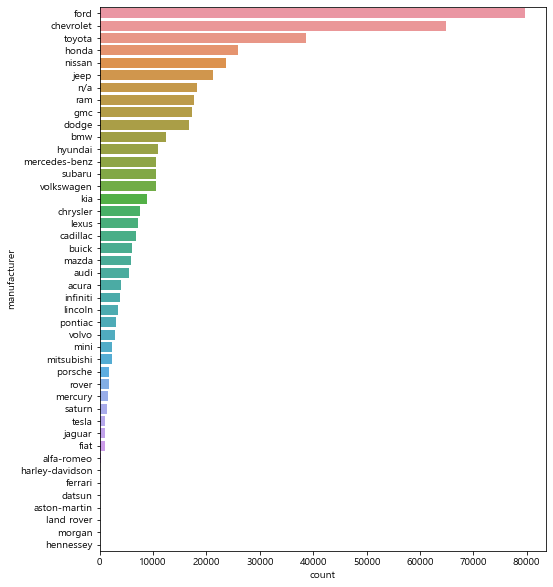

In [101]:
# manufacturer 시각화
countplot('manufacturer')

In [102]:
df.columns

Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'age'], dtype='object')

#### 2) model

In [103]:
len(df['model'].value_counts())

31520

In [104]:
# length가 너무 긴 데이터의 경우 value_counts()를 해도 전체 데이터를 출력해주지 않는다.
df['model'].value_counts()

f-150                       8370
silverado 1500              5964
1500                        4211
camry                       4033
accord                      3730
                            ... 
dart sxt 4dr sedan             1
century custom 4dr sedan       1
sienna le 8 passenger          1
soul base 4dr crossover        1
caravana                       1
Name: model, Length: 31520, dtype: int64

In [105]:
# for문을 활용해 전체 내용을 출력할 수 는 있다.
# 모델명 : df['model'].value_counts().index
# 모델 별 숫자 : df['model'].value_counts()

import reprlib
r = reprlib.Repr()
#r.maxlist = 100       # max elements displayed for lists
#r.maxstring = 10    # max characters displayed for strings
for model, num in zip(df['model'].value_counts().index, df['model'].value_counts()):
  print(r.repr([model, num]))

['f-150', 8370]
['silverado 1500', 5964]
['1500', 4211]
['camry', 4033]
['accord', 3730]
['altima', 3490]
['civic', 3479]
['escape', 3444]
['silverado', 3090]
['explorer', 2941]
['equinox', 2923]
['corolla', 2801]
['wrangler', 2788]
['mustang', 2652]
['malibu', 2649]
['tacoma', 2649]
['fusion', 2608]
['grand cherokee', 2574]
['focus', 2491]
['grand caravan', 2445]
['2500', 2438]
['tahoe', 2266]
['cr-v', 2230]
['impala', 2127]
['cruze', 2125]
['sonata', 2062]
['elantra', 2010]
['sentra', 1914]
['jetta', 1870]
['prius', 1863]
['rav4', 1832]
['odyssey', 1831]
['outback', 1791]
['silverado 2500hd', 1780]
['edge', 1735]
['charger', 1718]
['sierra 1500', 1696]
['rogue', 1687]
['forester', 1514]
['traverse', 1489]
['camaro', 1472]
['pilot', 1441]
['wrangler unlimited', 1412]
['3500', 1396]
['suburban', 1381]
['f-250', 1357]
['corvette', 1345]
['sienna', 1328]
['highlander', 1318]
['f150', 1311]
['acadia', 1308]
['tundra', 1302]
['soul', 1294]
['sierra', 1272]
['cherokee', 1220]
['f-350', 1164

['impala limited lt', 21]
['golf gti s', 21]
['f150 4wd', 21]
['cr-v touring', 21]
['silverado 1500 ltz z71', 21]
['q50 3.7 sedan 4d', 21]
['rouge', 21]
['gladiator gl...sport leveled', 21]
['f150 xlt xtr 4x4 half ton', 21]
['250', 21]
['sentra sl', 21]
['econoline e150', 21]
['magnum sxt', 21]
['s5 3.0t quattro cabriolet', 21]
['w4500', 21]
['juke s', 21]
['f-150 svt raptor', 21]
['golf tsi s hatchback', 21]
['pacifica limited', 21]
['cls550', 21]
['tribeca limited', 21]
['rx 350 awd', 21]
['malibu lt 1lt', 21]
['e320', 21]
['versa sr sedan 4d', 21]
['pt cruiser convertible', 21]
['e350 cutaway', 21]
['crown victoria lx', 21]
['q45', 21]
['cobalt ss', 21]
['sienna le awd', 21]
['zephyr', 21]
['silverado 2500 ltz lo', 21]
['fleetwood brougham', 21]
['rogue awd', 21]
['Isuzu Rodeo', 21]
['charger srt8', 21]
['forester 2.5 x', 21]
['f-150 lariat 4x4', 21]
['juke sv', 21]
['avalon xle', 21]
['International 4400 DT466', 21]
['ISUZU NPR', 21]
['ranger supercab xlt', 21]
['SUZUKI SX4', 21]
[

['mazda5 sport', 8]
['tundra trd maxed out', 8]
['blazer ls', 8]
['yaris ia sedan 4d', 8]
['xts luxury sedan 4d', 8]
['rav4 adventure awd', 8]
['nv passenger', 8]
['accord coupe ex', 8]
['prius persona series', 8]
['z3 m roadster', 8]
['mkz awd leather loaded', 8]
['spectra lx', 8]
['forester s', 8]
['mazda3 touring leather', 8]
['echo 2 door', 8]
['Freightliner Sprinter 3500', 8]
['Oldsmobile Aurora', 8]
['rio s', 8]
['1-series', 8]
['maserati ghibli s q4', 8]
['cruze lt hatchback', 8]
['impreza wrx wagon', 8]
['beetle 1.8t se', 8]
['lesabre 4dr sdn custom', 8]
['silverado 2500hd crew cab', 8]
['2015', 8]
['Smart fortwo', 8]
['3100 truck', 8]
['escalade luxury awd', 8]
['INTERNATIONAL WATER TRUCK', 8]
['new compass latitude 4wd', 8]
['Silverado', 8]
['transit 350 15 passenger', 8]
['avalon xle sedan 4d', 8]
['2005', 8]
['cla cla 250', 8]
['1 series 135i coupe 2d', 8]
['b4000', 8]
['x6m', 8]
['a3 tdi premium plus', 8]
['van 1500', 8]
['2dr sedan', 8]
['International DuraStar 4300', 8]


['f-150 xlt sport package', 5]
['1500 st standard cab', 5]
['is 350 sedan 4d', 5]
['lasabre', 5]
['sierra hd', 5]
['econoline pickup', 5]
['glk 350 4matic', 5]
['optima sxl turbo', 5]
['international scout ii', 5]
['c8500 bucket truck', 5]
['cts-v coupe', 5]
['caballero', 5]
['explorer pick up', 5]
['1500￼', 5]
['f-350 xl', 5]
['q7 3.6 premium quattro', 5]
['cruse', 5]
['grand caravan se handicap', 5]
['envision premium', 5]
['beetle r-line', 5]
['renegade latitude fwd gas', 5]
['malibu maxx ls', 5]
['s5 quattro coupe 2d', 5]
['express 2500 work', 5]
['mustang ecoboost fastback', 5]
['ud2000', 5]
['sierra 1500 classic', 5]
['ram1500', 5]
['explorer sport 4x4 gas suv', 5]
['silverado ltz 4x4', 5]
['titan platinum reserve', 5]
['accent limited sedan 4d', 5]
['altima 2.5 sl sedan', 5]
['suzuki vitara', 5]
['5500 chassis', 5]
['210 wagon', 5]
['liberty 4dr limited 4wd', 5]
['sierra 3500 dually', 5]
['legacy premium 2.5i awd', 5]
['Bentley Arnage', 5]
['e350 bucket van', 5]
['equinox lt 1lt

['Lamborghini ...n LP 640-4 EV', 3]
['rogue sport fwd s', 3]
['civic 4dr cvt ex', 3]
['rabbit convertible', 3]
['1500 laramie 4wd leather do', 3]
['3500 crew cab aisin transmi', 3]
['camry le 5-speed automatic', 3]
['sanoma', 3]
['Yukon', 3]
['oddysey', 3]
['gr caravan w/ stow n go', 3]
['161164', 3]
['crv-lx awd', 3]
['f250 super duty crew cab l', 3]
['silverado 2500 lt crew', 3]
['impreza wrx ...-speed manual', 3]
['Isuzu Ascender', 3]
['cx-9 awd 4dr sport', 3]
['trax fwd 4dr ls w/1ls', 3]
['2500 laramie diesel', 3]
['outlander phev sel', 3]
['rogue sv w/sl package', 3]
['grand+caravan', 3]
['malibu class... sdn ls w/1fl', 3]
['viper rt/10 27k original', 3]
['2500 quad cab st pick', 3]
['semtra sv', 3]
['forte sedan', 3]
['transit 150 medium roof', 3]
['camry hybrid se', 3]
['-Impala', 3]
['rx 400h awd 4dr hybrid', 3]
['sierra 2500hd duramax', 3]
['qx50 base', 3]
['Land+Rover R...+Rover+Evoque', 3]
['element ex 4wd', 3]
['polara', 3]
['murano awd 4dr sl', 3]
['benz 380 se', 3]
['3500

['e-150 wheelchair van', 2]
['coach', 2]
['Haulmark trailer', 2]
['yukon denali 4wd suv', 2]
['sportwagen', 2]
['a3 2.0 tdi premium plus', 2]
['tahoe high country', 2]
['1500 sport 4wd', 2]
['durango sxt awd gas suv', 2]
['civic lx sedan 2.0', 2]
['f-250sd 4wd truck', 2]
['edge se awd suv', 2]
['grand cherok...aredo 4dr suv', 2]
['2015 f350 lariat', 2]
['mercedez benz c300', 2]
['Freightliner CL 120', 2]
['impreza premium awd', 2]
['xe 35t r-sport', 2]
['ion 1', 2]
['200 series touring', 2]
['cooper panoramic roof', 2]
['silverado 2500hd class', 2]
['avalanche lt sport', 2]
['wrx sti launch edition', 2]
['Volkswagon Passat', 2]
['volkswagon passat wagon', 2]
['gx 460 premium sport', 2]
['e150 passenger', 2]
['f-250 xlt super duty', 2]
['crosstrek limited awd', 2]
['is 300 f sport', 2]
['benz slk 320', 2]
['super duty f-250 plow', 2]
['f-250sd lariat 4x4', 2]
['transit-250', 2]
['360 spider', 2]
['f-150 svt raptor 4x4', 2]
['elantra gt limited', 2]
['rav4 limited 4wd', 2]
['1960 willys 

['335i sport', 2]
['x1 xdrive28i m-sport pkg', 2]
['sentra 2.0 sr cvt', 2]
['pathfinder s...eed automatic', 2]
['murano le awd cvt', 2]
['JAY sunseeker', 2]
['Hyster', 2]
['xc60 t6 momentum', 2]
['z3 1.9 2dr convertible', 2]
['huyndai sonata', 2]
['tacoma reg cab 4x4', 2]
['elantra sport fwd gas', 2]
['xf s', 2]
['q7 3.0 quattro tdi', 2]
['sienna se premium 8', 2]
['versa note sv fwd gas', 2]
['mazdaspeed6', 2]
['pathfinder se 4wd', 2]
['mazda3 i touring sedan', 2]
['gla 250 4matic', 2]
['accord ex-l w/navigation', 2]
['rdx fwd w/technology pkg', 2]
['charger gt rwd', 2]
['odyssey se minivan 4d', 2]
['des-Benz A-Class', 2]
['galant es 4-speed automatic', 2]
['eclipse gs 4-speed automatic', 2]
['sonata ltd x...eed automatic', 2]
['odyssey ex w...eed automatic', 2]
['6 i grand touring sedan', 2]
['4runner sr5 sport edition', 2]
['Toyoda Tendra TRD', 2]
['f-250 lariat 4x4', 2]
['e-350 sd xl', 2]
['focus zxw se', 2]
['silverado k2500hd', 2]
['suburban ltz 4x4 gas', 2]
['2500 crew cab slt',

['Hyndai Elantra Value Edition', 1]
['sorento ex automatic', 1]
['88 Suzuki Samurai', 1]
['passat se 1.8t', 1]
['corvette coupe lt1🌟', 1]
['Corvette Stingray', 1]
['tl tech sh-awd', 1]
['mkiv gti', 1]
['sierra 2500hd work truck 2dr', 1]
['c250 coupe', 1]
['routon se', 1]
['535d xdrive m sport', 1]
['q5 quattro premium plus awd', 1]
['tundra double cap', 1]
['f-250 xlt hd', 1]
['juke fwd sv', 1]
['vanagon doka', 1]
['equinox awd 2lt', 1]
["Isuzu P'up Diesel", 1]
['b350 cargo van', 1]
['rav4 hybrid le awd (natl)', 1]
['milan premier awd', 1]
['Avenger Kit Car', 1]
['liteace van', 1]
['vanette camper', 1]
['delica spacegear', 1]
['Maserati Biturbo', 1]
['hzj75 landcruiser', 1]
['wranger x model', 1]
['navigator base', 1]
['cooper countryman jcw', 1]
['optima ex sedan', 1]
['hhr lt sport', 1]
['2007 Suzuki Grand Vitara', 1]
['Tiyota Prius', 1]
['q3 2.0t prestige', 1]
['fit 5dr sport', 1]
['v30', 1]
['Blue Bird Al... All Canadian', 1]
['- All Americ... All Canadian', 1]
['highlander hybrid 

['saratoga 2 door hdtp', 1]
['chayane', 1]
['scottsdale c30', 1]
['c-class c 300 automatic', 1]
['Isuzu Trooper Limited', 1]
['Toyot Matrix', 1]
['f150 f 150', 1]
['wranger jk', 1]
['durango sxt rwd', 1]
['c320 4matic', 1]
['explorer limited 2011', 1]
['comfort coupe', 1]
['benz cla-class cla250', 1]
['silverado 1500 lt1 4wd', 1]
['1967 CJ5 V6', 1]
['escalade luxury 4x4 gas', 1]
['ia Sportage', 1]
['jetta gli autobahn', 1]
['camaro 2ss coupe', 1]
['crv exl awd gas suv auto', 1]
['CX-5', 1]
['veracruz gls', 1]
['sienna xle fwd gas auto', 1]
['1970 Plymouth Road Runner', 1]
['sedona lx fwd gas auto', 1]
['deisel 5.9 3500', 1]
['300 awd touring', 1]
['a3 quattro awd', 1]
['f150 fx4 ecoboost', 1]
['brat', 1]
['dakota slt 4x4 v8', 1]
['accord ex w/ navigation', 1]
['f-100 panel', 1]
['320i sedan', 1]
['f-250 sd xlt', 1]
['golf alltrack tsi', 1]
['benz c-280 amg', 1]
['Volkswagon thing', 1]
['Navigator', 1]
['911 turbo/965', 1]
['impala ls 2009', 1]
['terrain sle2 awd', 1]
['sierra deisel du

['coupe s', 1]
['2001 Monte Carlo SS', 1]
['highlander limited suv', 1]
['civic sedan 4dr cvt ex-l', 1]
['Triumph Trident', 1]
['hiunday sonata', 1]
['charger 4dr sdn se rwd', 1]
['4runner trd pro 4wd (natl)', 1]
['super duty f... cab 172" xlt', 1]
['traxx', 1]
["f-150 xl 2wd reg cab 8' box", 1]
['sierra 1500 ...le cab 143.5"', 1]
['camaro 2dr conv ss w/2ss', 1]
['f250 lariat crew cab 4x4', 1]
['silverado 15...b 157" custom', 1]
['liberty sport 4x4, 4 door', 1]
['yukon xl 2wd 4dr denali', 1]
['sierra 2500h...b 159" denali', 1]
['cts4 performance', 1]
['Oldsmobile omaga', 1]
['2009 Saab 9-5 Wagon', 1]
['Maserati M138 spyder', 1]
['tacoma 2wd d... sport (natl)', 1]
['ls-430', 1]
['gx gx 460 4wd', 1]
['Passion Coupe', 1]
['2500 heavy duty', 1]
['silverado 15...lt trail boss', 1]
['benz sl 500 convertible', 1]
['impala 4dr sdn ltz w/2lz', 1]
['enclave cx fwd', 1]
['328 ci', 1]
['f-150 supercab flareside', 1]
['f-150 sherrod', 1]
['Suzuki Jimny', 1]
['clse', 1]
['sonata 2010', 1]
['ridgelin

['tribute lx 4x4', 1]
['sebring touring edition', 1]
['charger hemi', 1]
['2009 TBSS', 1]
['durango st', 1]
['International Harvester', 1]
['xj l portfolio', 1]
['optima ex sedan 4dr', 1]
['grand cherokee laredo 4x4 -', 1]
['sedona minivan 4d', 1]
['EXPEDITION EDDIE BAUER', 1]
['s 63 amg', 1]
['escape s fwd 4dr', 1]
['e class e350', 1]
['ODYSSEY EX-L', 1]
['a5 quattro 2.0t', 1]
['640i m package conve', 1]
['romeo giulia ti 19 sporpa', 1]
['silverado lt 1500 rwd', 1]
['terrain sle suv fwd', 1]
['f150 xlt supercrew 4wd', 1]
['regal cxl turbo to1', 1]
['liberty diesel cdr', 1]
['mustang convertible coupe', 1]
['3 itouring', 1]
['cherokee ltd.', 1]
['conquest tsi turbo', 1]
['Mazda3 Hatchback 2.0', 1]
['focus sedan sel', 1]
['57 RAMBLER CUSTOM 6', 1]
['1999 C2500 Suburban 6.5TD', 1]
['v70 3.2 wagon', 1]
['e350 convertible', 1]
['benz c250 coupe sport', 1]
['patriot fwd 4dr sport', 1]
['prius #6 hybrid', 1]
['prius hybrid two', 1]
['prius hybrid touring', 1]
['cj7.', 1]
['freightliner 120',

['1997 Astro van AWD', 1]
['MG MGB Roadster', 1]
['b150', 1]
['f450 heavy duty', 1]
['c34 hd', 1]
['wrangler sport-x', 1]
['328i gt', 1]
['colorado lt v6', 1]
['335i conv', 1]
['Caddilac Escalade', 1]
['Miles Electric series 40', 1]
['Dymac Electric 48V pick up.', 1]
['venza fwd v6', 1]
['ats 4 - 2.0t', 1]
['2011Ranger', 1]
['s60 r 2.5t awd', 1]
['soul gt-line turbo', 1]
['q50 awd red sport', 1]
['2-door coupe', 1]
['2008 sti', 1]
['corolla s.', 1]
['Chrsler 200 Convertible', 1]
['sierra c2500', 1]
['ROLLS ROYCE silver cloud ll', 1]
['Acterra, Sterling', 1]
['2006 International 4200', 1]
['f-150 lariat crew 5.5ft bed', 1]
['f-150 2wd supercrew 145 xlt', 1]
['contour se', 1]
['odyssey touring elite whee', 1]
['3500 cummins 4x4', 1]
['2500 crew cab cummins', 1]
['2500 4wd crew cab 149 larami', 1]
['ciivic', 1]
['Oldsmobile Vista Cruiser', 1]
['sienna wheelchair handica', 1]
['sorento ex v6 – awd', 1]
['tacoma trd sport double c', 1]
['sprinter passenger 2500', 1]
['1500 crew cab 4x4 eco 

['sle 3500', 1]
['standard sedan.', 1]
['silverado w/t', 1]
['300c limited touring', 1]
['ridgeline awd rtl-e', 1]
['Chevrolete Blazer', 1]
['impala ltz 2lz', 1]
['1500 slt bighorn', 1]
['durango 4x4 sxt', 1]
['Chevorlet Venture Van', 1]
['econoline e-350van', 1]
['regal premium turbo', 1]
['thunderbird 1995', 1]
['benz 300 ce', 1]
['formula firebird', 1]
['911 carrera s c2s cabri', 1]
['mark vi', 1]
['stratus rt', 1]
['Saab 9-2x Aero', 1]
['04 Monte Carlo', 1]
['lucerne cxl -- se', 1]
['express 3500 1 ton su', 1]
['sierra (model c10903)', 1]
['panamera s', 1]
['cts vsport', 1]
['lierty', 1]
['2015 FREIGHTLINER COLUMBIA', 1]
['2005 FREIGHTLINER CENTURY', 1]
['2005 FREIGHTLINER COLUMBIA', 1]
['sts awd', 1]
['routan se with rse', 1]
['forester 2.5 x premium aw', 1]
['sienna limited 7-passenge', 1]
['grand cherokee/laredo 4x4', 1]
['2002 Grand Am SE', 1]
['liberty/sport 4wd', 1]
['m550', 1]
['Chevolet Equniox LT', 1]
['Smart Car Pa...n Convertible', 1]
['patriot latiitude', 1]
['mustang g

['f150 xl fx4', 1]
['2500 hd z71 4x4', 1]
['2001 Silvera...500HD Duramax', 1]
['QX80 FX35 QX60 QX70', 1]
['pathfinder sv midnight', 1]
['fusion 2015 titanium', 1]
['automatic', 1]
['Mercededs s550', 1]
['Triumph TR 6', 1]
['wrangler sport 4wd jk', 1]
['quest 3.5sl', 1]
['2500 laramie 4wd 149wb', 1]
['pilot elite w/res navi awd', 1]
['sierra 1500 slt 2wd 147wb', 1]
['3500 hd 4x4', 1]
['land cruiser 4x4', 1]
['limo', 1]
['yukon denali 4w', 1]
['All  Makes And Models', 1]
['s60 t6 awd', 1]
['2005 silverado pick up truck', 1]
['2006 Saab 9-5 turbo', 1]
['2012 suburu legacy', 1]
['2002GMC Sanoma', 1]
['Suzuki sx4', 1]
['Toyota-JEEP-...-Honda-Subaru', 1]
['Saab 9-2X Aero', 1]
['Suzuki forenza', 1]
['jeepgrand ch...elaredo 4x4 -', 1]
['hemi rumble bee', 1]
['2006 Scion xB', 1]
['spirit r/t', 1]
['forte 5d hatchback', 1]
['Toyota-Subar...-Chevy-Ram-VW', 1]
['silverado 1500 lt hybrid', 1]
['60', 1]
['Fort T Bucket', 1]
['f250 super duty powerstroke', 1]
['58092', 1]
['silverado 1500 crew ltz', 

- 데이터 출력값이 너무 많아서 일부만 출력

```python
countplot('model') 
```
으로 시각화를 하려 했으나, 데이터가 너무 커서 메모리상의 한계로 에러가 발생

- 각 모델명 별로 1개의 값이 있는 경우도 있다.
- 공백이 2칸 이상 있는 데이터 등 스크래핑을 통해 수집된 데이터로서 발생하는 몇몇 에러들이 보인다.

#### 3) condition

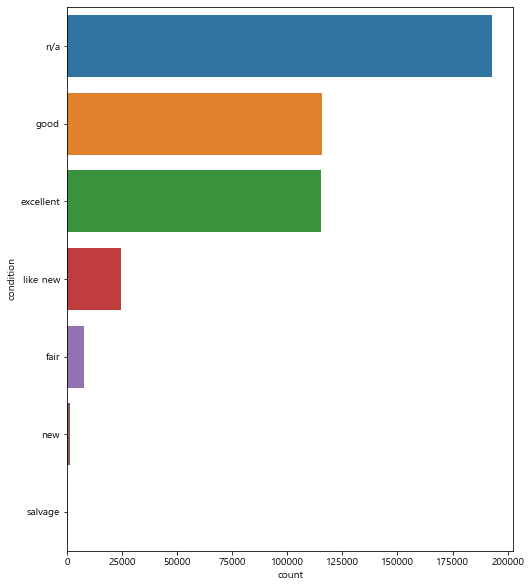

In [106]:
countplot('condition')

- salvage : 상태가 매우 안좋은 것을 의미
- n/a 값이 가장 많다. 
    - 차량 상태를 명확히 보여주지 않기 위해 입력 자체를 하지 않았을 가능성이 있어 보인다.
    - 차량 상태에 관련된 변수(age, odometer 등)를 통해 유추해서 채워넣는 등 전처리를 시도해볼 필요성 있음

#### 4) cylinders

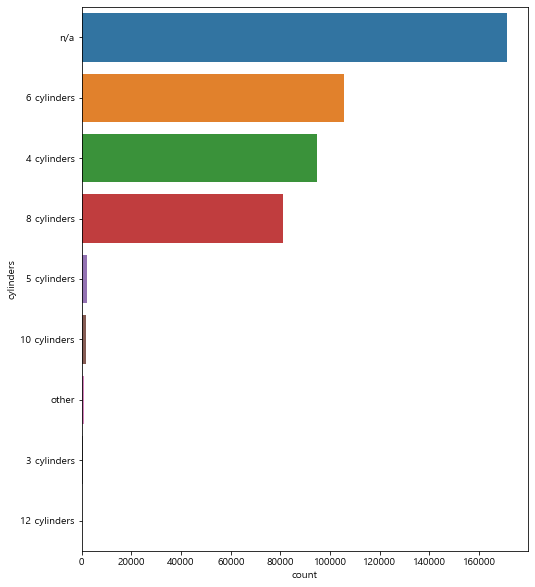

In [107]:
countplot('cylinders')

- n/a값이 대부분을 차지
- 여러가지 전처리 방식을 고민해볼 필요가 있다.
    - 데이터 수가 소수인 값들을 n/a에 포함시켜서 분석을 진행 하는 방식
    - n/a 데이터를 다른 컬럼으로 유추해서 채워넣는 방식

#### 5) fuel

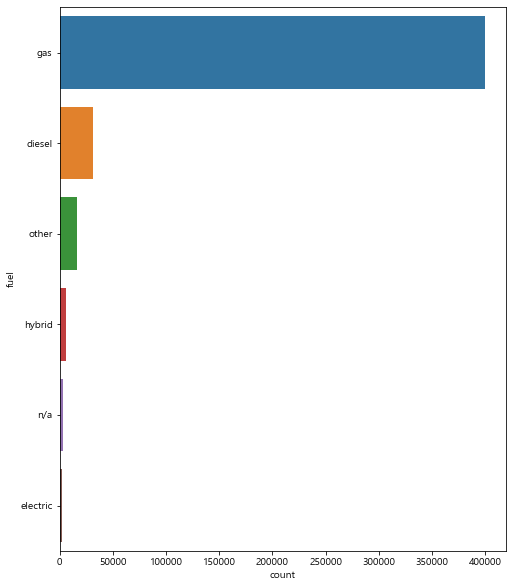

In [108]:
countplot('fuel')

- 대부분 gas 차량

#### 6) transmission

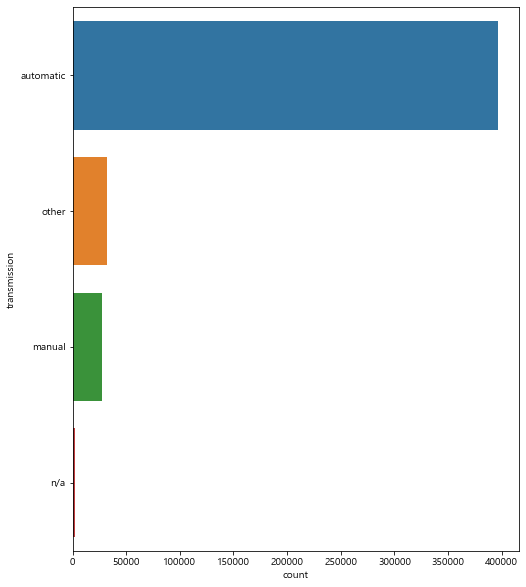

In [109]:
countplot('transmission')

- 대부분이 automatic 차량
- n/a값이 적어서 drop해도 분석에 지장 없을 듯

#### 7) drive

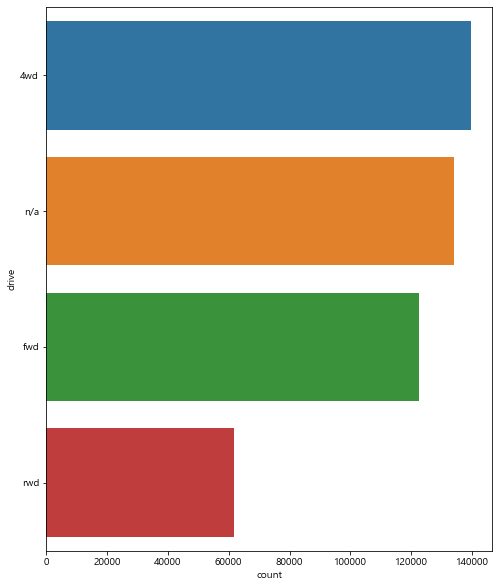

In [110]:
countplot('drive')

- 전반적으로 데이터 분포가 고른편
- 별다른 전처리 없이 학습시켜도 될 듯 하다.

#### 8) size

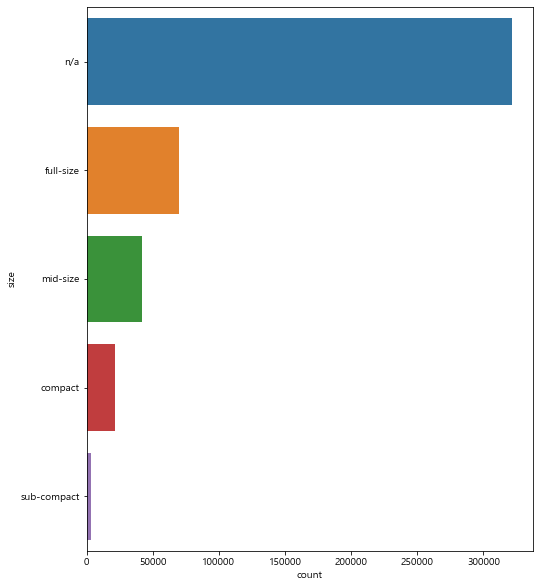

In [111]:
countplot('size')

- n/a가 가장 많다.
- 통계적 분석 결과에 따라 유의미할 것으로 판단되면 사용하되, 그렇지 않으면 제거하는 것을 고려

#### 9) type

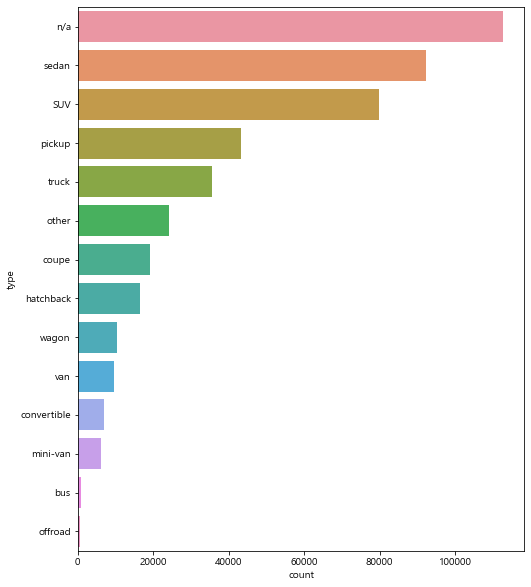

In [112]:
countplot('type')

- n/a가 가장 많다.

#### 10) paint_color

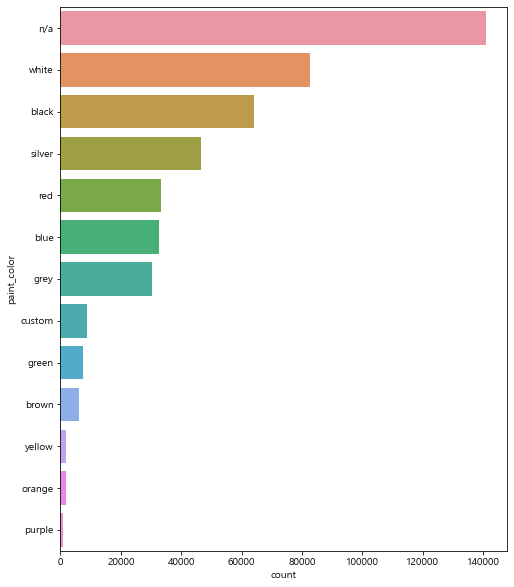

In [113]:
countplot('paint_color')

- n/a값이 가장 많다.
- custom에 따른 가격차이를 확인해볼 필요 있음
    - custom은 취향 차이에 따라 호불호가 갈릴 수 있을 것 같음.(=어떤 의미론 유의미한 값이 될 가능성이 있음)

### 수치형 데이터 분석

- 데이터의 범위가 너무 넓고 많은 경우 histplot은 ram할당량 초과로 연산이 안되는 경우가 많다.
- 특히, price의 경우 df.describe()로 확인했을때도 데이터의 분포가 이상할 것으로 예상되었다.

#### 1) price

<AxesSubplot:xlabel='price'>

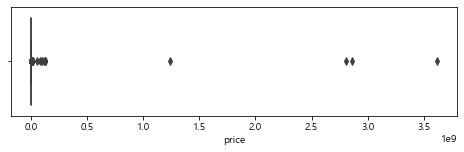

In [114]:
fig = plt.figure(figsize=(8, 2))
sns.boxplot(x='price', data=df)

- boxplot으로 보기엔 데이터의 분포등을 확인하긴 어렵다.
- outliers가 상당히 많다는 것은 대략적으로 파악 가능하다.
- 이럴땐 rugplot(x,y축 기반 주변 분포도, 개별 데이터 위치 파악 용이)으로 시각화 해보는 것이 데이터 분포 파악에는 더 유용하다.

<AxesSubplot:xlabel='price'>

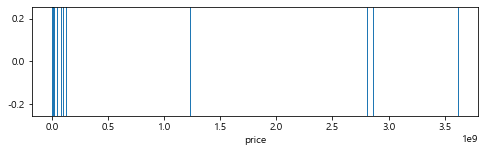

In [115]:
fig = plt.figure(figsize=(8, 2))
sns.rugplot(x='price', data=df, height=1)

- 1e9(10의 9승) 인 outlier는 제외하더라도, 데이터가 한쪽에 너무 치중되어 있어 유의미한 통계적 의미를 찾기가 어렵다.

#### 2) odometer
- df.describe()로 봤을때, 이상치로 예상되는 값의 크기가 상당했다.

<AxesSubplot:xlabel='odometer'>

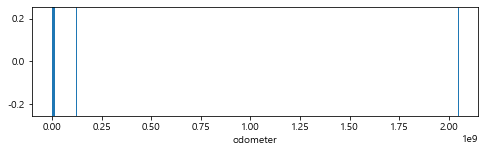

In [116]:
fig = plt.figure(figsize=(8, 2))
sns.rugplot(x='odometer', data=df, height=1)

- 1e9(10의 9승) 인 outlier는 제외하더라도, 데이터가 한쪽에 너무 치중되어 있어 유의미한 통계적 의미를 찾기가 어렵다.

#### 3) age

<AxesSubplot:xlabel='age', ylabel='Count'>

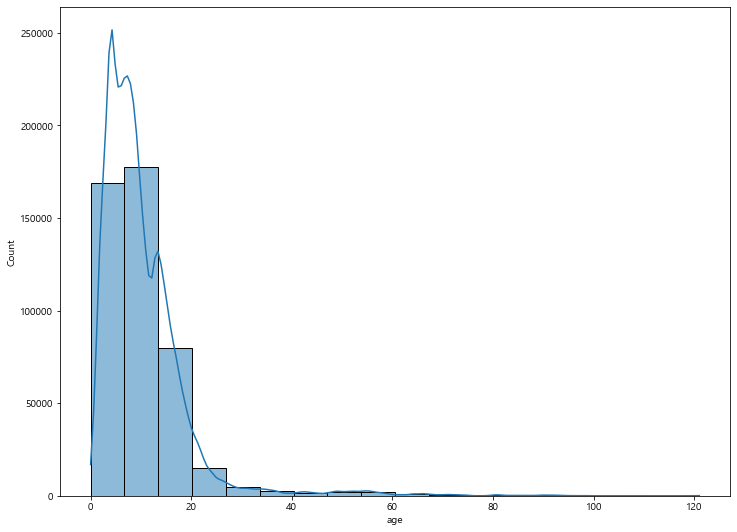

In [117]:
sns.histplot(x='age', data=df, bins=18, kde=True)

- 5 ~ 10년 정도 된 차량이 가장 많은 분포를 보인다.

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        458213 non-null  object 
 1   price         458213 non-null  int64  
 2   manufacturer  439993 non-null  object 
 3   model         453367 non-null  object 
 4   condition     265273 non-null  object 
 5   cylinders     287073 non-null  object 
 6   fuel          454976 non-null  object 
 7   odometer      402910 non-null  float64
 8   title_status  455636 non-null  object 
 9   transmission  455771 non-null  object 
 10  drive         324025 non-null  object 
 11  size          136865 non-null  object 
 12  type          345475 non-null  object 
 13  paint_color   317370 non-null  object 
 14  age           457163 non-null  float64
dtypes: float64(2), int64(1), object(12)
memory usage: 52.4+ MB


## 데이터 클리닝

### 범주형 데이터 시각화 & 분석

- 범주형 데이터 x price 의 연관성 분석

<AxesSubplot:xlabel='manufacturer', ylabel='price'>

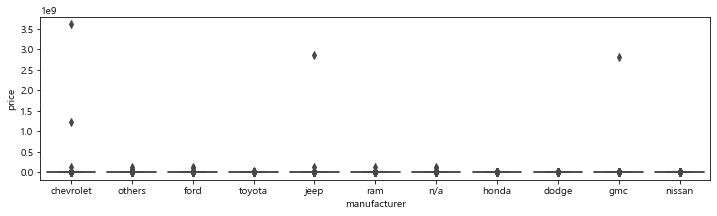

In [165]:
# Boxplot 계열로 범주형 데이터를 시각화하여 분석
# null값은 n/a로 채워서 확인
fig = plt.figure(figsize=(12, 3))
sns.boxplot(x='manufacturer', y='price', data=df.fillna('n/a'))

<AxesSubplot:xlabel='fuel', ylabel='price'>

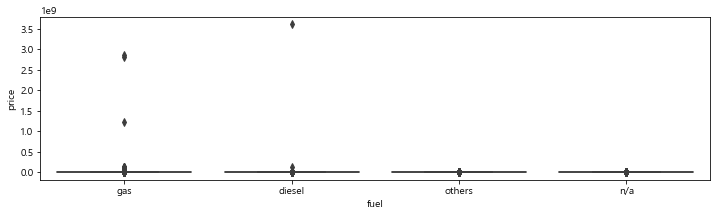

In [166]:
fig = plt.figure(figsize=(12, 3))
sns.boxplot(x='fuel', y='price', data=df.fillna('n/a'))

- 위에서 대략적으로 살펴보았듯이 n/a값이 너무 많거나, 데이터가 특정 범주에 몰려있는 경우가 많다.<br>
- 이로 인해 시각화를 하여도 제대로된 분석을 하기가 어렵다.<br>
- 데이터 클리닝을 통해 한번 정제해줄 필요가 있다.<br>
- **범주형 데이터와 수치형 데이터 클리닝을 진행한 후**에 다시 시각화 & 분석을 시도해야 한다.

### 범주형 데이터 클리닝

- 범주형 데이터(categorical)를 클리닝할 경우 보통 4가지 방법중 하나를 사용한다.
    - null 데이터가 포함된 row를 제거
    - null 데이터를 others로 치환하기
    - 너무 소수의 값만을 보유한 범주를 others로 치환하기
    - classifier를 학습시켜, null 데이터를 추정하여 채워넣기

#### 1) manufacturer

- 너무 소수의 값만을 보유한 범주를 others로 치환하기

In [121]:
# null값들을 others로 값을 부여 
# 시각화 , value_counts 등을 할때 제대로 결과가 나오도록 하기 위함.

# category 별 counts가 많은 데이터부터 내림차순으로 보여진다.
df['manufacturer'].fillna('others').value_counts()

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
others             18220
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63


In [122]:
# 범주형 데이터 시각화용 함수 생성
# 변곡점 그리는 함수 기본 설정은 convex
# 필요시 변경 가능
def viz_val_counts(col, shape='convex'):
    
    # 데이터 입력
    counts = df[col].fillna('others').value_counts()
    x = range(len(counts))
    
    # 변곡점(elbow point) 찾기
    from kneed import KneeLocator
    kn = KneeLocator(x, counts, curve=shape, direction='decreasing')
    
    # 격자 설정
    plt.grid(True, color='lightgray', zorder=0) 
    
    # 시각화
    plt.plot(x, counts)
    
    # elbow point 그리기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='r')
    
    # elbow point 수치 표시
    plt.text(kn.knee+0.13, counts.median(), kn.knee, fontsize = 15, color='red')
    
    # 시각화한 범주형 변수들의 value_counts출력
    print(counts)

# 결과 확인용 value_counts 함수 생성
def val_counts(col):
    return df[col].value_counts()

- 각 컬럼(카테고리) 의 개수가 몇개인지 시각화 하는 그래프
- category 값이 너무 많기 때문에, 일일히 category명이 들어가도록 시각화 하면 데이터를 제대로 살피기 어려움
- 소수 값을 가진 category는 others로 치환할 것이기 때문에 변수명이 중요하진 않음
- elbow point(변곡점)을 시각화
    - others에 포함시킬 변수를 몇개로 정할지 참조할 때 사용.

In [123]:
def viz_val_counts2(col, num, shape='convex'):
    
    # 데이터 입력
    counts = df[col].fillna('others').value_counts()
    x = range(len(counts[:num]))
    
    # 변곡점(elbow point) 찾기
    from kneed import KneeLocator
    kn = KneeLocator(x, counts[:num], curve=shape, direction='decreasing')
    
    # 격자 설정
    plt.grid(True, color='lightgray', zorder=0) 
    
    # 시각화
    plt.plot(x, counts[:num])
    
    # elbow point 그리기
    plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='r')
    
    # elbow point 수치 표시
    plt.text(kn.knee+0.13, counts[:num].median(), kn.knee, fontsize = 15, color='red')
    
    # 시각화한 범주형 변수들의 value_counts출력
    print(counts)

- 데이터가 극단적으로 몰려있을때, 세부적으로 조정하여 보고자 할때 사용

ford               79666
chevrolet          64977
toyota             38577
honda              25868
nissan             23654
jeep               21165
others             18220
ram                17697
gmc                17267
dodge              16730
bmw                12352
hyundai            10975
mercedes-benz      10628
subaru             10510
volkswagen         10489
kia                 8854
chrysler            7499
lexus               7119
cadillac            6743
buick               6009
mazda               5931
audi                5583
acura               4008
infiniti            3714
lincoln             3338
pontiac             3037
volvo               2866
mini                2330
mitsubishi          2301
porsche             1779
rover               1662
mercury             1645
saturn              1393
tesla               1067
jaguar              1060
fiat                 955
alfa-romeo           187
harley-davidson      139
ferrari               96
datsun                63


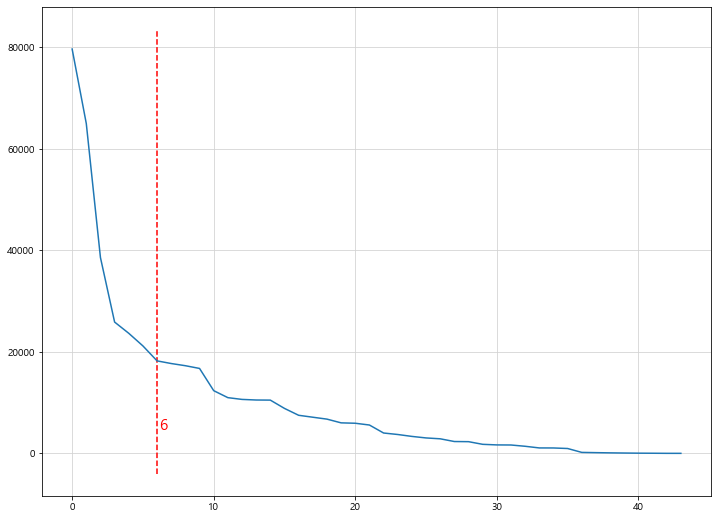

In [124]:
# 시각화 결과 
viz_val_counts('manufacturer')

In [125]:
# 해당 그래프의 category 명을 확인하고자 한다면 아래와 같이 확인 가능
# counts가 value_counts를 해서 내림차순 정렬된 것이기 때문에 앞에 나오는 값일 수록 데이터가 많은 것.
df['manufacturer'].fillna('others').value_counts().index

Index(['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'others', 'ram', 'gmc', 'dodge', 'bmw', 'hyundai', 'mercedes-benz', 'subaru', 'volkswagen', 'kia', 'chrysler', 'lexus', 'cadillac', 'buick', 'mazda', 'audi', 'acura', 'infiniti', 'lincoln', 'pontiac', 'volvo', 'mini', 'mitsubishi', 'porsche', 'rover', 'mercury', 'saturn', 'tesla', 'jaguar', 'fiat', 'alfa-romeo', 'harley-davidson', 'ferrari', 'datsun', 'aston-martin', 'land rover', 'morgan', 'hennessey'], dtype='object')

- 상위 10개의 데이터만 category로 남기고, 나머지는 others로 치환
- 급격히 감소하는 지점은 6개이지만, 범주값이 너무 적어서 10개로 지정

- others로 치환하는 함수 생성
```python
def to_others(col, n_categorical):
    counts = df[col].fillna('others').value_counts()
    df[col] = df[col].apply(lambda s: s if str(s) not in counts.index[n_categorical:] else 'others')
```

 - 위의 함수가 기본 형식.
 - 다만 유지해야할 범주의 개수보다 drop해야할 범주의 개수가 더 많을 경우 labmda 연산에서 counts.index[n_categorical:] 를 매번 불러오기 때문에 매우 오래 걸린다.
 - 따라서 미리 counts.index[n_categorical:] 를 변수화 하여 사용하면 메모리 부하를 줄일 수 있다. (아래 함수 참조)

In [126]:
# 지정한 개수 이외의 범주들을 others로 만드는 함수 생성
def to_others(col, n_categorical):
    counts = df[col].fillna('others').value_counts()
    others = counts.index[n_categorical:]
    df[col] = df[col].apply(lambda s: s if str(s) not in others else 'others')

- n_categorical에 others 포함 총 몇개의 범주변수로 만들 것인지 입력
- 시각화한 그래프로 확인한 변곡점을 기반으로 선택한 범주화의 값을 입력하여 변경

In [127]:
# 총 10개의 범주로 변경
to_others('manufacturer',10)

# 결과 시각화
val_counts('manufacturer')

others       134392
ford          79666
chevrolet     64977
toyota        38577
honda         25868
nissan        23654
jeep          21165
ram           17697
gmc           17267
dodge         16730
Name: manufacturer, dtype: int64

- 데이터의 구성이 클리닝 전에 비해 훨씬 단순해지고 깔끔해졌다.

#### 2) region

columbus               3818
rochester              3592
jacksonville           3504
springfield            3293
fayetteville           2990
                       ... 
siskiyou county          28
susanville               17
west virginia (old)      11
fort smith, AR           11
sioux city, IA            1
Name: region, Length: 405, dtype: int64


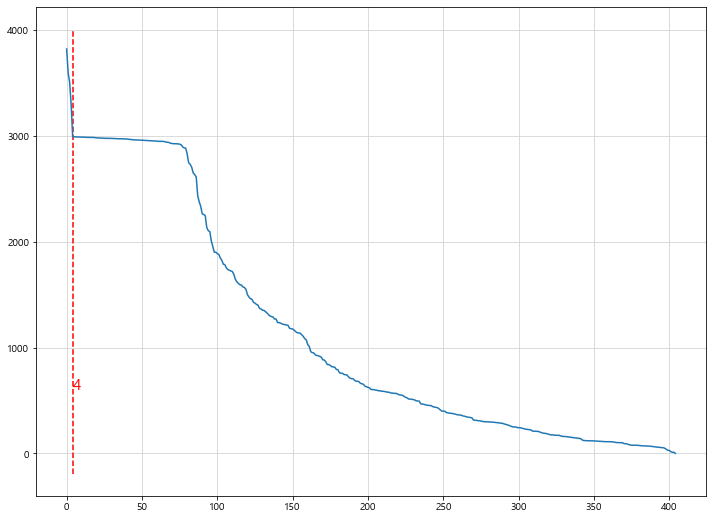

In [129]:
viz_val_counts('region')

- elbow point는 4, 상위 5개로 범주화
- 405개의 범주를 모두 사용하면 좋지만, 이 경우 차원의 저주 문제를 피하기 어려워 최대한 단순화 하고자 함.

In [130]:
to_others('region',5)

# 결과 확인
val_counts('region')

others          441016
columbus          3818
rochester         3592
jacksonville      3504
springfield       3293
fayetteville      2990
Name: region, dtype: int64

#### 3) model

f-150                 8370
silverado 1500        5964
others                4846
1500                  4211
camry                 4033
                      ... 
MG MGB Roadster          1
1997 Astro van AWD       1
rogue sv awd cvt         1
HUMMER H-3               1
caravana                 1
Name: model, Length: 31521, dtype: int64


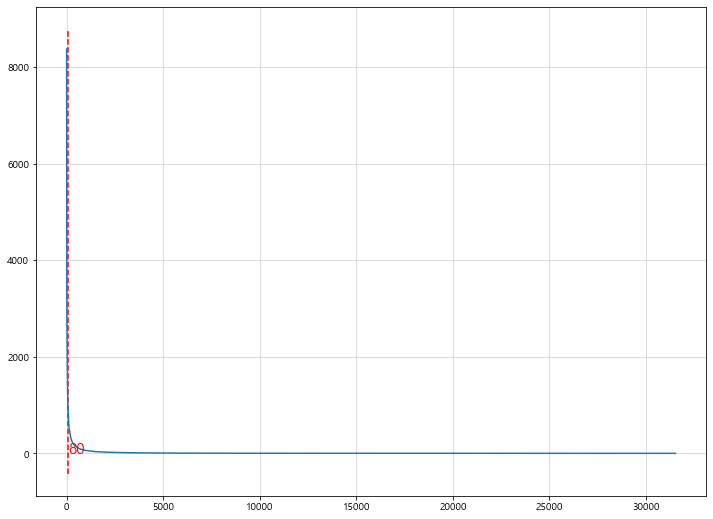

In [132]:
# raw 상태의 분포 확인
viz_val_counts('model')

- 분포가 매우 극단적 (상위 소수에 값이 몰려있다.)
- 조금 더 자세하게 들여다볼 필요가 있다.

f-150                 8370
silverado 1500        5964
others                4846
1500                  4211
camry                 4033
                      ... 
MG MGB Roadster          1
1997 Astro van AWD       1
rogue sv awd cvt         1
HUMMER H-3               1
caravana                 1
Name: model, Length: 31521, dtype: int64


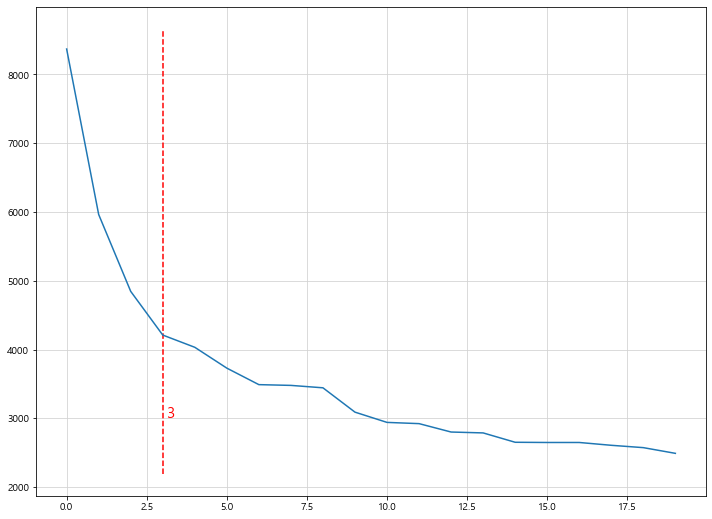

In [133]:
viz_val_counts2('model',20)

- 상위 20개 범주로만 봤을때의 변곡점은 3이지만, 최대한 많은 변수를 가져가기 위해 10개로 범주화
- 급격히 감소하는 구간을 거의다 포함할 수 있을 것으로 기대

In [134]:
to_others('model', 10)

# 결과 확인
val_counts('model')

others            413556
f-150               8370
silverado 1500      5964
1500                4211
camry               4033
accord              3730
altima              3490
civic               3479
escape              3444
silverado           3090
Name: model, dtype: int64

#### 4) condition

others       192940
good         115685
excellent    115206
like new      24553
fair           7740
new            1428
salvage         661
Name: condition, dtype: int64


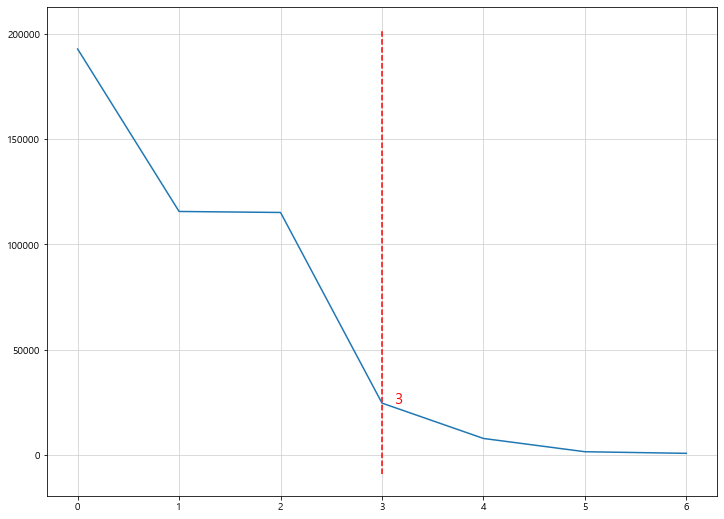

In [136]:
viz_val_counts('condition')

- 변곡점에 해당하는 3을 기준으로 others 로 치환해도 될 것 같다.

In [137]:
to_others('condition', 3)

# 결과 확인
val_counts('condition')

good         115685
excellent    115206
others        34382
Name: condition, dtype: int64

#### 5) cylinders

others          171140
6 cylinders     105677
4 cylinders      94767
8 cylinders      81179
5 cylinders       2058
10 cylinders      1543
other             1112
3 cylinders        550
12 cylinders       187
Name: cylinders, dtype: int64


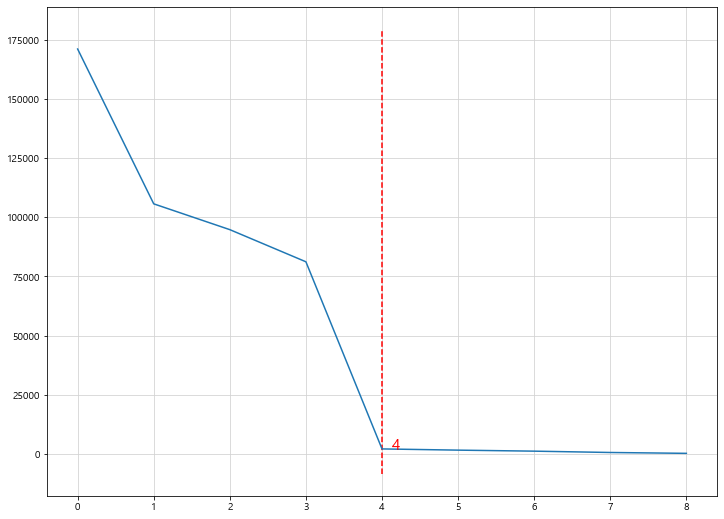

In [139]:
viz_val_counts('cylinders')

- 변곡점인 4부터 데이터 개수가 거의 같다.
- 변곡점을 기준으로 others로 치환한다.

In [140]:
to_others('cylinders', 4)

# 결과 확인
val_counts('cylinders')

6 cylinders    105677
4 cylinders     94767
8 cylinders     81179
others           5450
Name: cylinders, dtype: int64

#### 6) fuel

gas         399399
diesel       31077
other        16359
hybrid        5790
others        3237
electric      2351
Name: fuel, dtype: int64


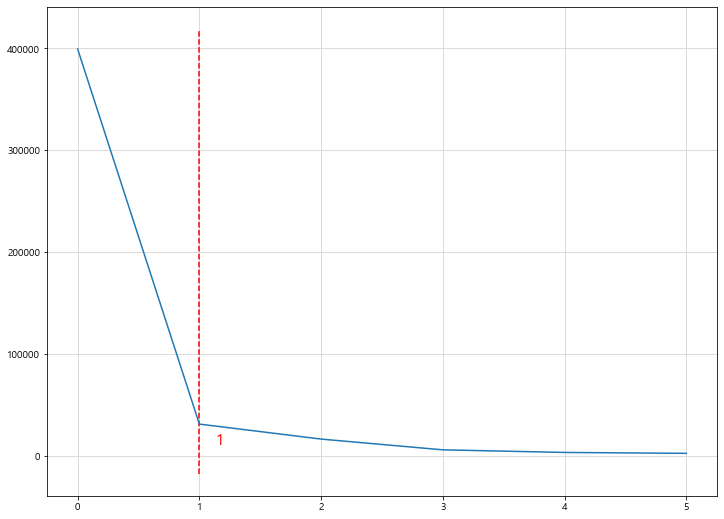

In [142]:
viz_val_counts('fuel')

- 변곡점은 1이다. 
- 가급적 많은 데이터를 살리기 위해 그래프의 기울기변화가 거의 없는 3을 기준으로 클리닝 진행
- other가 이미 있으므로, 함수에 들어갈 기준값은 2로 입력해서 other이 others가 되도록 진행

In [143]:
to_others('fuel', 2)

# 결과 확인
val_counts('fuel')

gas       399399
diesel     31077
others     24500
Name: fuel, dtype: int64

#### 7) title_status

clean         439626
rebuilt         8698
salvage         4233
others          2577
lien            2091
missing          794
parts only       194
Name: title_status, dtype: int64


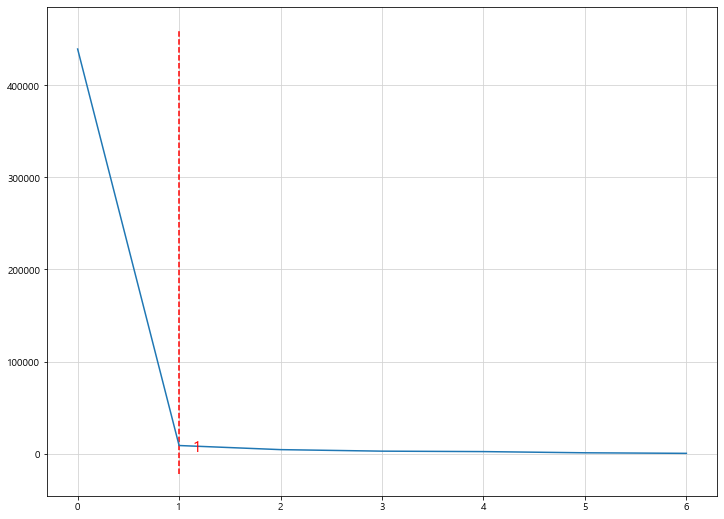

In [145]:
viz_val_counts('title_status')

- clean 이 대부분
- 도메인 지식 검색 결과 cat title은 차량 소유에 필요한 '서류' 
- 특별히 필요한 데이터가 아닌 듯 하여 drop 하기로 결정

In [146]:
df.drop('title_status', axis=1, inplace=True)

#### 8) transmission

automatic    396322
other         32186
manual        27263
others         2442
Name: transmission, dtype: int64


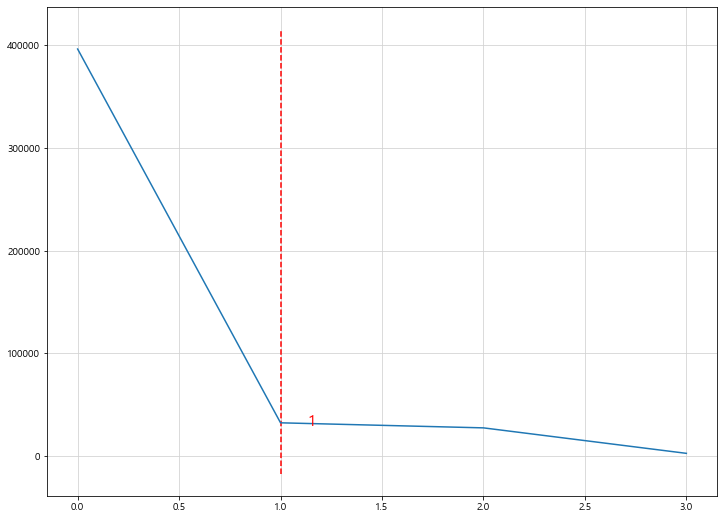

In [148]:
viz_val_counts('transmission')

- 변곡점은 1이지만, 기존 데이터가 3개 카테고리로 잘 분류되어 있어 추가 처리가 필요 없다.

#### 9) drive

4wd       139693
others    134188
fwd       122602
rwd        61730
Name: drive, dtype: int64


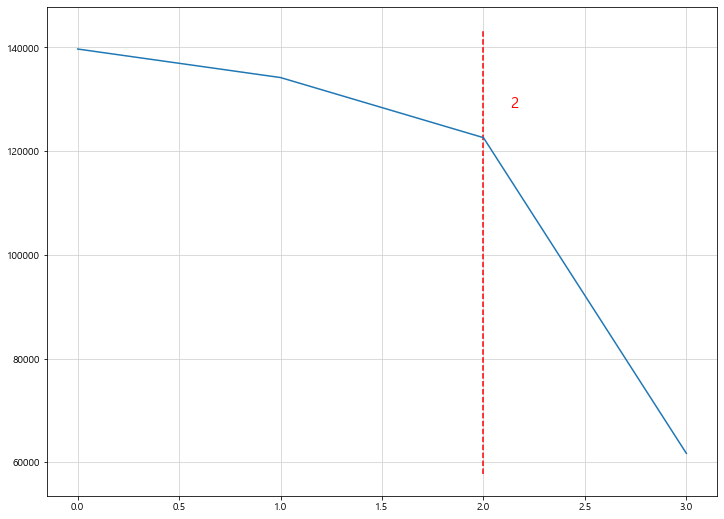

In [150]:
viz_val_counts('drive','concave')

- 변곡점은 2 이지만, 값이 차이가 나는 3의 경우도 약 6만개의 데이터가 있으므로 그대로 사용

#### 10) size

others         321348
full-size       69736
mid-size        41782
compact         21825
sub-compact      3522
Name: size, dtype: int64


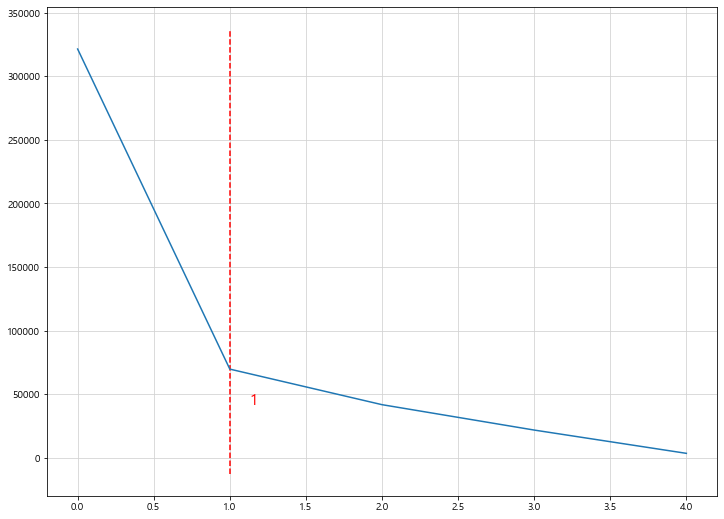

In [152]:
viz_val_counts('size')

- 변곡점은 1
- 2부터 기울기가 줄어드는 것을 감안하여 최종 2개의 카테고리 값을 갖도록 조정

In [153]:
to_others('size', 2)

# 결과 확인
val_counts('size')

full-size    69736
others       67129
Name: size, dtype: int64

#### 11) type

others         112738
sedan           92364
SUV             79882
pickup          43343
truck           35694
other           24160
coupe           19106
hatchback       16388
wagon           10473
van              9574
convertible      6864
mini-van         6263
bus               717
offroad           647
Name: type, dtype: int64


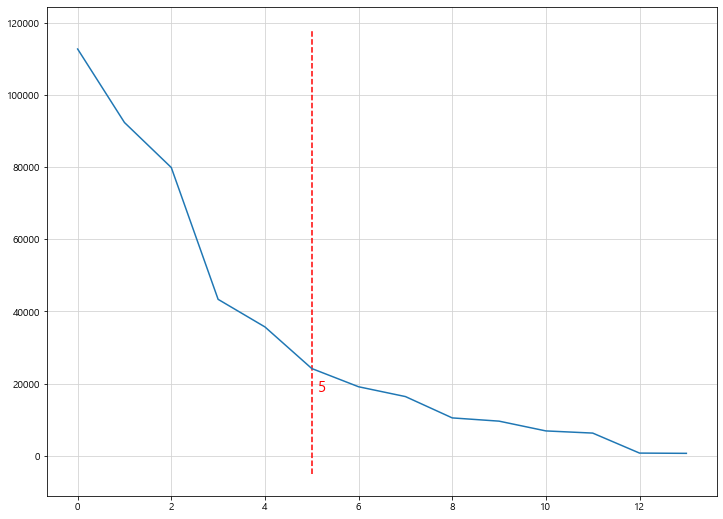

In [155]:
viz_val_counts('type')

- 변곡점은 5
- 상대적으로 기울기가 완만해지는 8을 기준으로 클리닝

In [156]:
# other과 others가 같이 있어서 컬럼명 변경하고 클리닝 진행
df.loc[df['type'] == 'other', 'type'] = 'others'

# 8개 범주로 클리닝
to_others('type', 8)


# 결과 확인
val_counts('type')

sedan        92364
SUV          79882
others       48225
pickup       43343
truck        35694
coupe        19106
hatchback    16388
wagon        10473
Name: type, dtype: int64

#### 12) paint_color

others    140843
white      82786
black      64145
silver     46722
red        33274
blue       32746
grey       30455
custom      8843
green       7631
brown       6028
yellow      2002
orange      1970
purple       768
Name: paint_color, dtype: int64


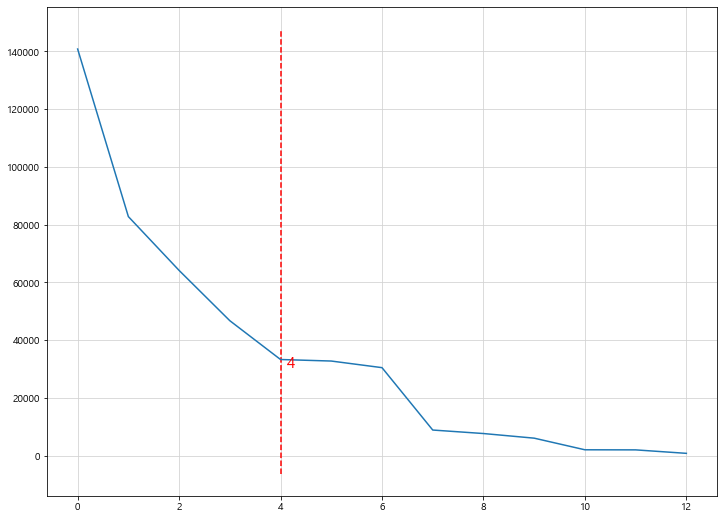

In [158]:
viz_val_counts('paint_color')

- 변곡점은 3
- 기울기가 완만해지는 7을 기준으로 클리닝 진행

In [159]:
to_others('paint_color', 7)

# 결과 확인
val_counts('paint_color')

white     82786
black     64145
silver    46722
red       33274
blue      32746
grey      30455
others    27242
Name: paint_color, dtype: int64

### 수치형 데이터 클리닝

#### 1) price

- 시각화하였을때 확인한 비정상적으로 높거나 낮은 이상치들을 제거해줄 필요가 있음

In [167]:
# quantile() 메소드를 이용하여 outlier 제거하고 시각화하여 확인
p1 = df['price'].quantile(0.99) # 상위 1% / 59900
p2 = df['price'].quantile(0.1) # 하위 10% / 651 (0.05까지는 0원)
print(p1, p2)

59900.0 651.0


In [168]:
# df에서 price 기준 대응되는 데이터의 범위를 재설정
df = df[(p1 > df['price']) & (df['price'] > p2)]

#### 2) odometer

In [169]:
o1 = df['odometer'].quantile(0.99)
o2 = df['odometer'].quantile(0.1)
print(o1, o2)

272803.10999999824 18593.0


In [170]:
df = df[(o1 > df['odometer']) & (df['odometer'] > o2)]

In [171]:
df.describe()

,price,odometer,age
count,322166.00,322166.00,321666.00
mean,15211.24,103341.83,10.22
std,11248.54,55049.52,7.07
min,652.00,18596.00,0.00
25%,6500.00,57454.00,6.00
50%,12000.00,98850.00,9.00
75%,20990.00,141000.00,13.00
max,59895.00,272742.00,121.00


- price
    - mean값과 중앙값(50%)가 비슷해졌다 = 가우시안 분포에 가까워 졌다.
    - 상위 25%값과 max값의 단위가 동일해졌다.
    
- odometer
    - mean값과 중앙값(50%)이 비슷해졌다. (상동) = 어느정도 과도하게 큰 값들은 quantile을 통해 클리닝이 되었다.
    - 상위 25%값과 max값이 단위는 다르지만 그 격차가 많이 해소되었다. 
    
    
- 결론적으로 상위 1%와 하위 10%를 클리닝 한 것은 적절한 조치였다.

### 범주형 데이터 시각화 & 분석(2)

- 범주형 데이터 x price 의 연관성 분석

In [127]:
df.columns

Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'age'],
      dtype='object')

In [188]:
# Boxplot 계열로 범주형 데이터를 시각화하여 분석하기

# boxplot 그리는 함수생성
def boxplot(x):
    fig = plt.figure(figsize=(14, 7))
    sns.boxplot(x=x, y='price', palette='Spectral', data=df);

#### 1) manufacturer X price

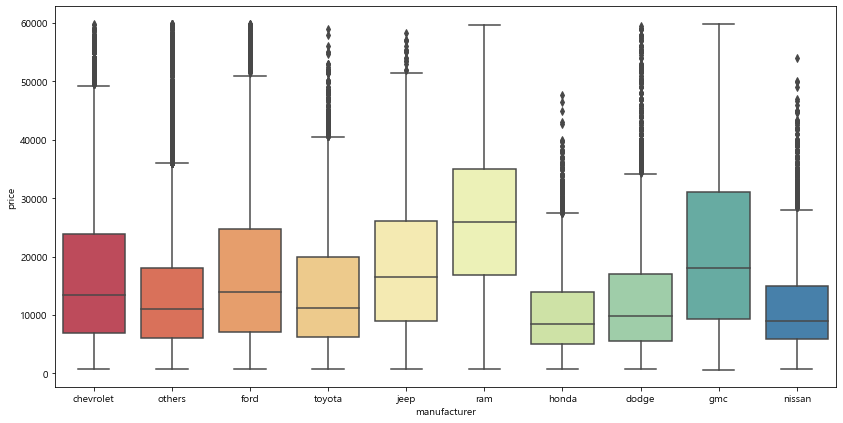

In [190]:
# Boxplot 계열로 범주형 데이터를 시각화하여 분석하기
boxplot('manufacturer')

- 모델별 평균 price의 차이가 존재한다. 
- price의 범위는(이상치를 포함하면) 대체로 거의 비슷하다. 
- (강력하진 않지만) 대략적으로 price를 결정짓는데 주요 요소중 하나가 될 수 있을 것으로 판단된다.

#### 2) region X price

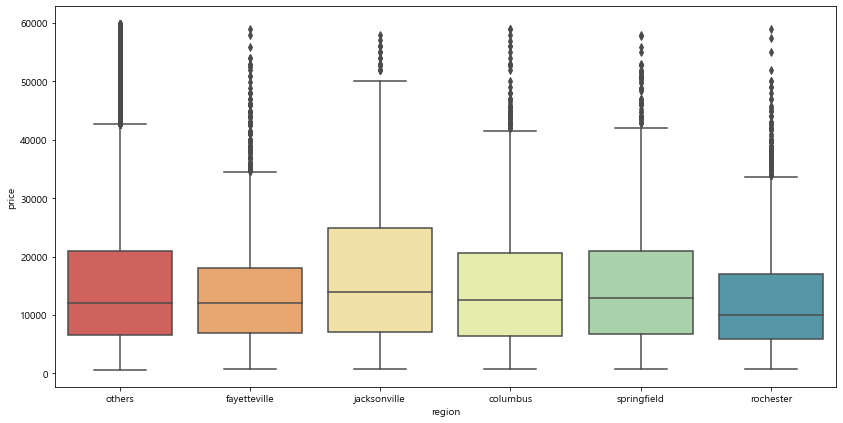

In [193]:
boxplot('region')

- 지역별로 평균 가격에는 큰 차이가 없다.
- 

#### 3) model X price

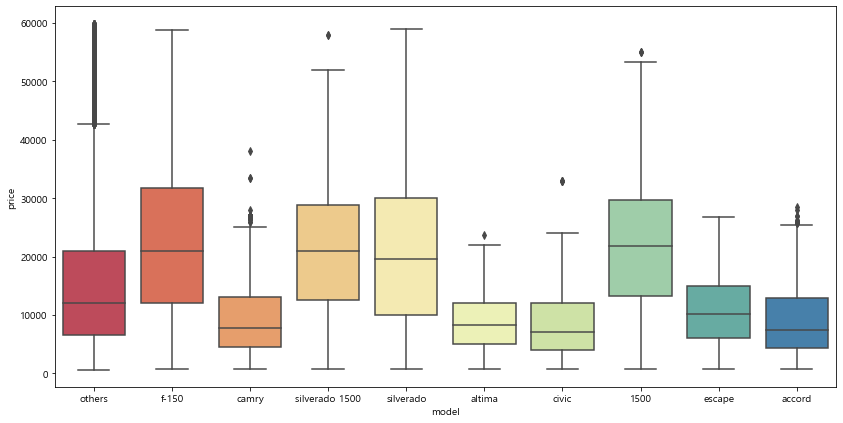

In [191]:
boxplot('model')

- 상대적으로 가격범위가 낮은 저렴한 모델들의 판매량이 많다.
- 저가 모델 그룹과 고가 모델 그룹으로 나누어지는 현상이 눈에 띈다.
- 동일 모델이어도 값의 범위 차이가 나는 것으로 보아 condition등 다른 요소에 의해 가격 차이가 발생하는 것으로 예상된다.

#### 4) condition X price

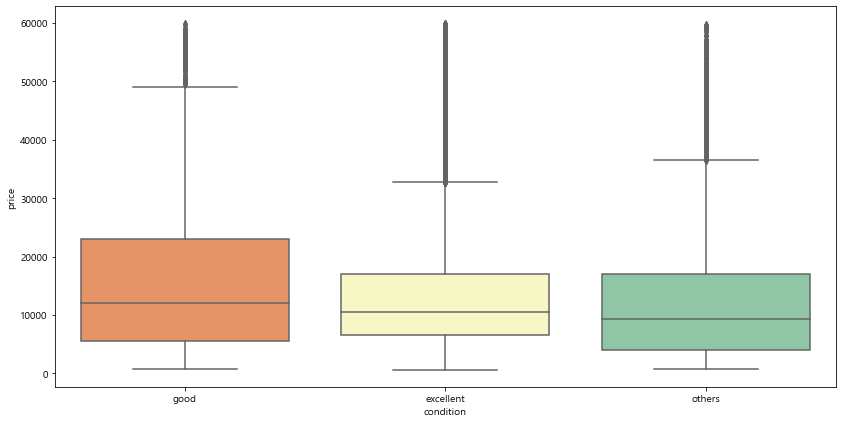

In [194]:
boxplot('condition')

#### 5) cylinders X price

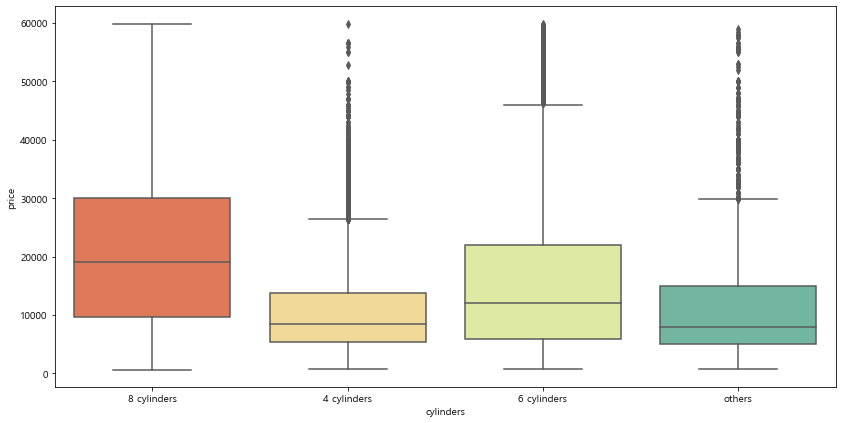

In [195]:
boxplot('cylinders')

#### 6) fuel X price

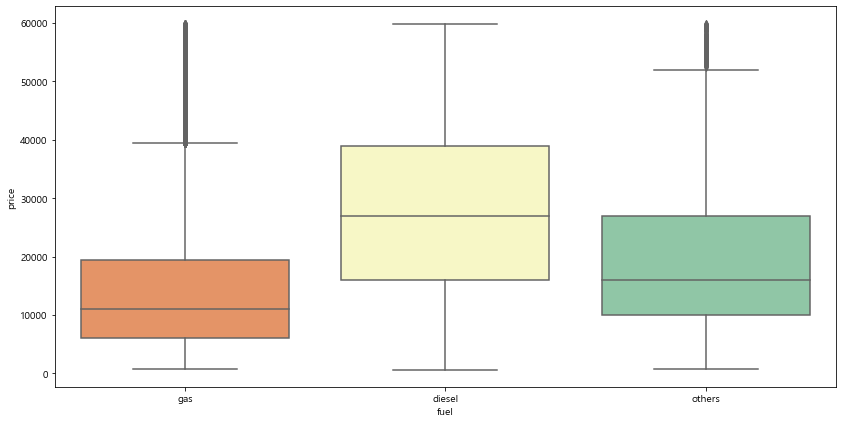

In [196]:
boxplot('fuel')

#### 7) transmission X price

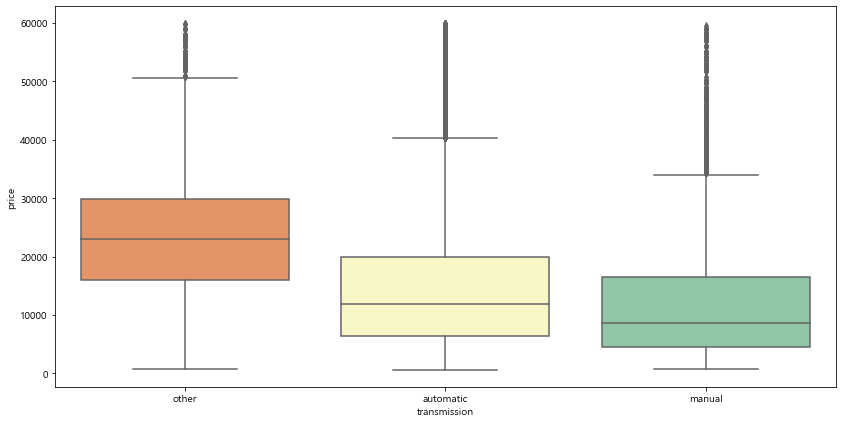

In [199]:
boxplot('transmission')

#### 8) drive X price

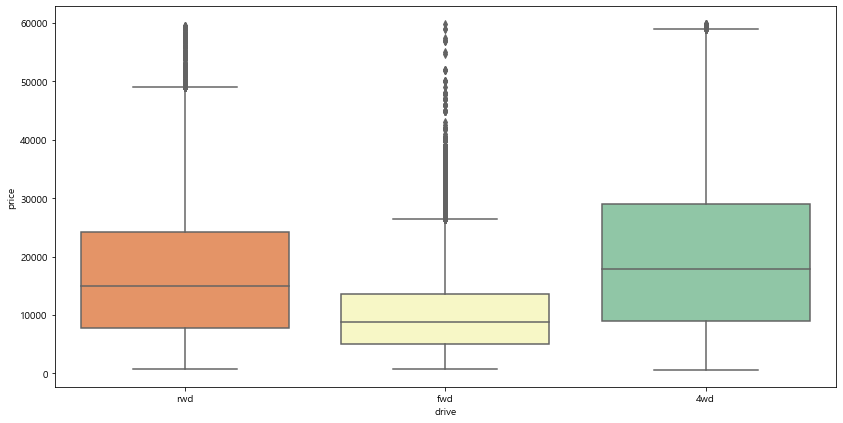

In [200]:
boxplot('drive')

#### 9) size X price

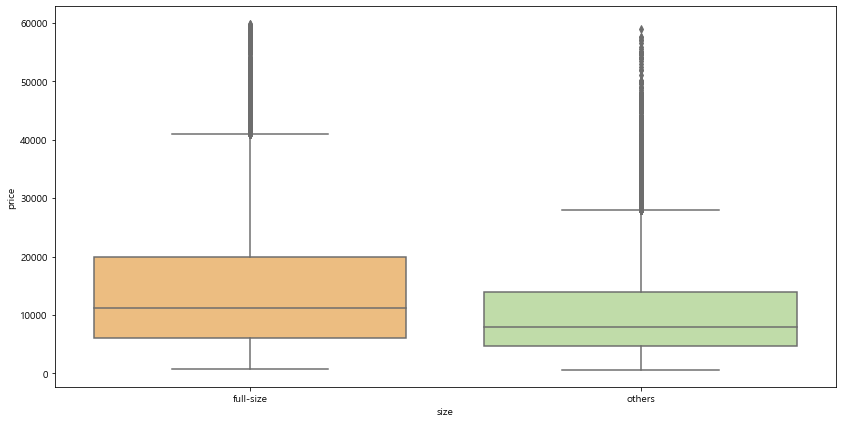

In [201]:
boxplot('size')

#### 10) type X price

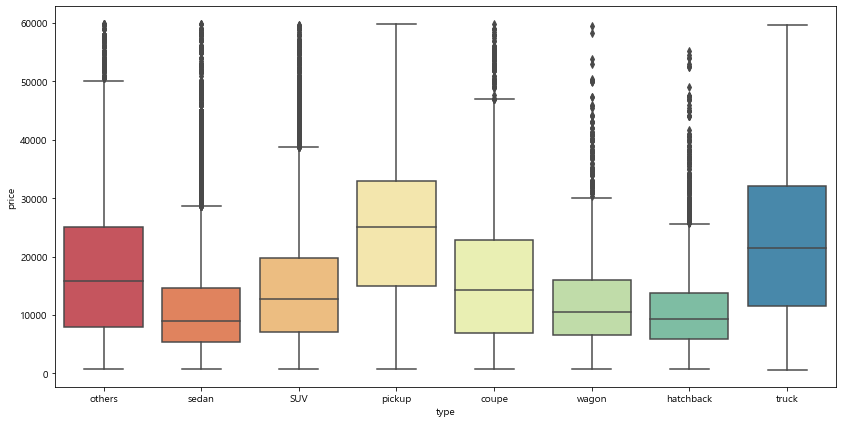

In [202]:
boxplot('type')

#### 11) paint_color X price

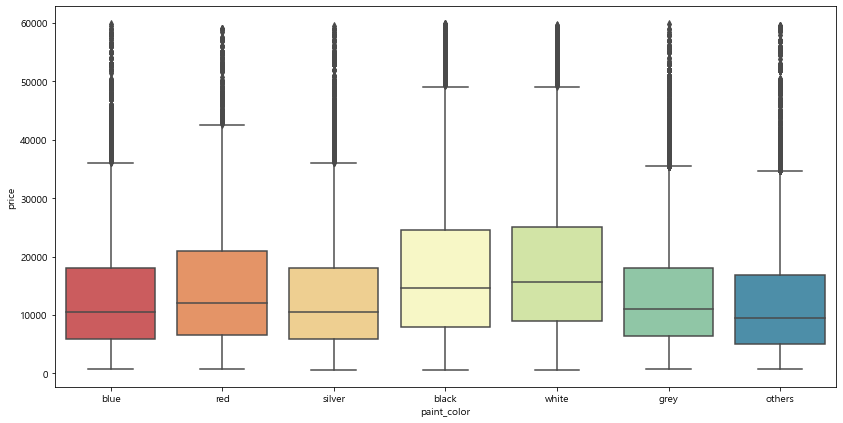

In [203]:
boxplot('paint_color')